<a href="https://colab.research.google.com/github/Lee-Gunju/AI-paper-code-review-for-personal-project/blob/master/Timeseries_anomaly_detection_using_an_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

In [ ]:
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(
    df_small_noise_url, parse_dates=True, index_col="timestamp"
)

df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_url, parse_dates=True, index_col="timestamp"
)

In [ ]:
df_small_noise

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120
...,...
2014-04-14 23:35:00,20.211195
2014-04-14 23:40:00,20.531041
2014-04-14 23:45:00,19.032127


In [ ]:
df_daily_jumpsup

,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739
...,...
2014-04-14 23:35:00,18.074649
2014-04-14 23:40:00,21.002014
2014-04-14 23:45:00,20.566713


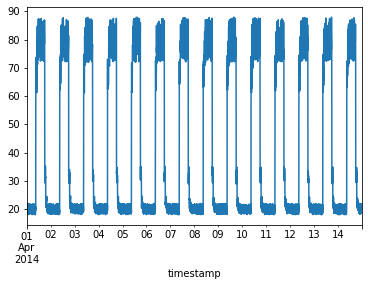

In [ ]:
fig, ax = plt.subplots()
df_small_noise.plot(legend = False, ax =ax)
plt.show()

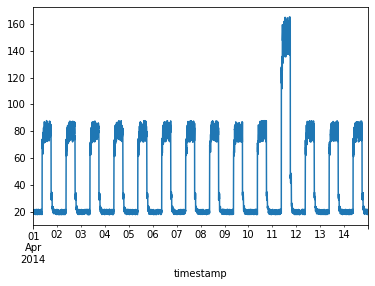

In [ ]:
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
plt.show()

In [ ]:
# Normalize and save the mean and std we get,
# for normalizing test data.

training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise - training_mean) / training_std
df_training_value

,value
timestamp,
2014-04-01 00:00:00,-0.858829
2014-04-01 00:05:00,-0.728993
2014-04-01 00:10:00,-0.848148
2014-04-01 00:15:00,-0.729586
2014-04-01 00:20:00,-0.731173
...,...
2014-04-14 23:35:00,-0.791647
2014-04-14 23:40:00,-0.780255
2014-04-14 23:45:00,-0.833640


In [ ]:
training_mean, training_std
df_training_value.values

array([[-0.85882857],
       [-0.72899302],
       [-0.84814772],
       ...,
       [-0.83364049],
       [-0.73510213],
       [-0.8460886 ]])

In [ ]:
TIME_STEPS = 288

# Generated training sequences for use in the model.
def create_sequences(values, time_steps = TIME_STEPS):
  output = []
  for i in range(len(values) - time_steps):
    output.append(values[i : (i + time_steps)])
  return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)


Training input shape:  (3744, 288, 1)


In [ ]:
model = keras.Sequential([
                          layers.Input(shape = (x_train.shape[1], x_train.shape[2])),
                          layers.Conv1D(filters=32, kernel_size= 7, padding='same', strides=2, activation='relu'),
                          layers.Dropout(rate = 0.2),
                          layers.Conv1D(filters=16, kernel_size = 7, padding = 'same', strides=2, activation='relu'),
                          layers.Conv1DTranspose(filters=16, kernel_size = 7, padding='same', strides=2, activation='relu'),
                          layers.Dropout(rate=0.2),
                          layers.Conv1DTranspose(filters=32, kernel_size = 7, padding='same', strides = 2, activation='relu'),
                          layers.Conv1DTranspose(filters= 1, kernel_size = 7, padding='same')
])

model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001), loss = 'mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 144, 32)           256       
_________________________________________________________________
dropout_7 (Dropout)          (None, 144, 32)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 72, 16)            3600      
_________________________________________________________________
conv1d_transpose_6 (Conv1DTr (None, 144, 16)           1808      
_________________________________________________________________
dropout_8 (Dropout)          (None, 144, 16)           0         
_________________________________________________________________
conv1d_transpose_7 (Conv1DTr (None, 288, 32)           3616      
_________________________________________________________________
conv1d_transpose_8 (Conv1DTr (None, 288, 1)           

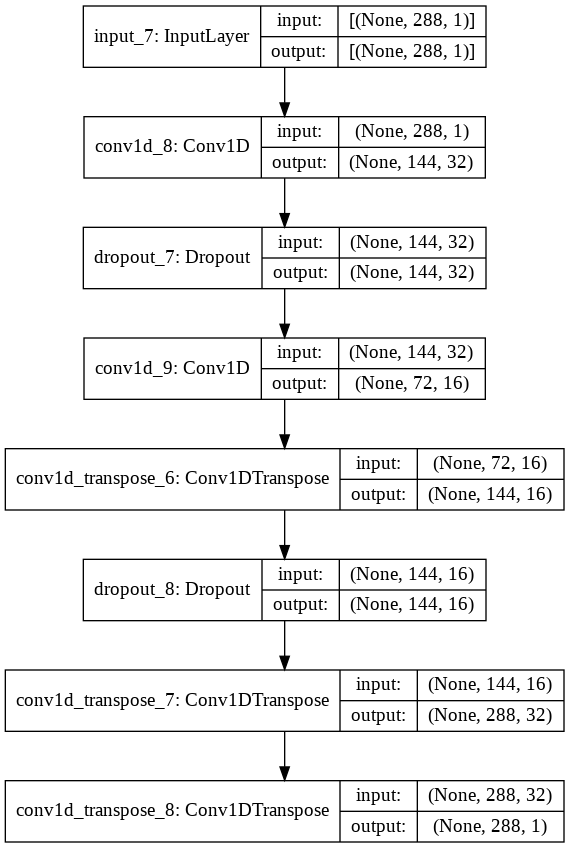

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
history = model.fit(x=x_train, y=x_train, epochs=50, batch_size=128, validation_split=0.1, callbacks=[keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=5, mode='min')])

Epoch 1/50
27/27 [==============================] - 1s 14ms/step - loss: 0.8079 - val_loss: 0.0672
Epoch 2/50
27/27 [==============================] - 0s 7ms/step - loss: 0.0861 - val_loss: 0.0431
Epoch 3/50
27/27 [==============================] - 0s 6ms/step - loss: 0.0613 - val_loss: 0.0392
Epoch 4/50
27/27 [==============================] - 0s 6ms/step - loss: 0.0529 - val_loss: 0.0339
Epoch 5/50
27/27 [==============================] - 0s 5ms/step - loss: 0.0469 - val_loss: 0.0303
Epoch 6/50
27/27 [==============================] - 0s 6ms/step - loss: 0.0417 - val_loss: 0.0279
Epoch 7/50
27/27 [==============================] - 0s 5ms/step - loss: 0.0374 - val_loss: 0.0250
Epoch 8/50
27/27 [==============================] - 0s 5ms/step - loss: 0.0333 - val_loss: 0.0232
Epoch 9/50
27/27 [==============================] - 0s 6ms/step - loss: 0.0304 - val_loss: 0.0228
Epoch 10/50
27/27 [==============================] - 0s 5ms/step - loss: 0.0283 - val_loss: 0.0218
Epoch 11/50
27/27 

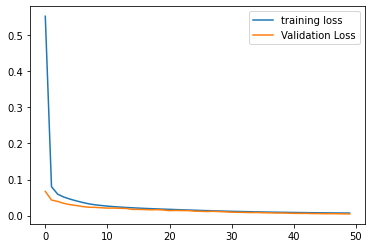

In [ ]:
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [ ]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
x_train_pred.shape

(3744, 288, 1)

In [ ]:
x_train.shape

(3744, 288, 1)

In [ ]:
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

In [ ]:
train_mae_loss.shape

(3744, 1)

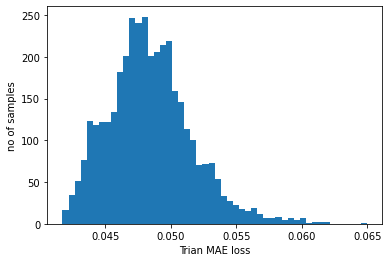

In [ ]:
plt.hist(train_mae_loss, bins = 50)
plt.xlabel('Trian MAE loss')
plt.ylabel('no of samples')
plt.show()

In [ ]:
# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)


Reconstruction error threshold:  0.06496706970049868


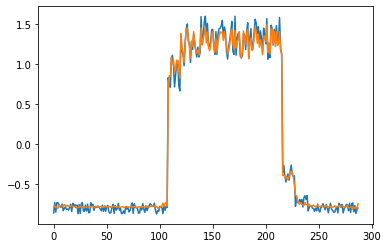

In [ ]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

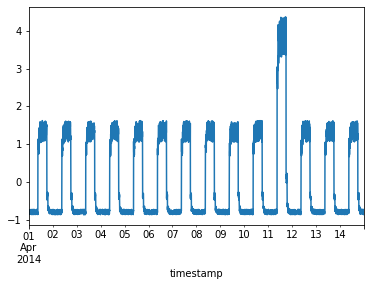

Test input shape:  (3744, 288, 1)


In [ ]:
def normalize_test(values, mean, std):
  values -= mean
  values /= std
  return values
  
df_test_value = (df_daily_jumpsup - training_mean) / training_std 
fig, ax = plt.subplots()
df_test_value.plot(legend = False, ax =ax)
plt.show() 

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis = 1)
test_mae_loss = test_mae_loss.reshape((-1))

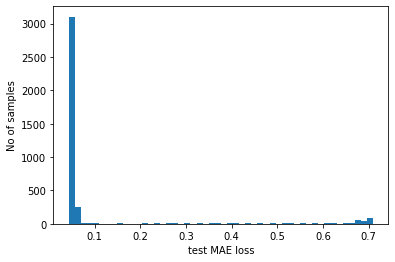

In [ ]:
plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

In [ ]:
# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

Number of anomaly samples:  403
Indices of anomaly samples:  (array([ 793, 2520, 2521, 2522, 2699, 2701, 2702, 2703, 2704, 2705, 2706,
       2707, 2708, 2709, 2710, 2711, 2712, 2713, 2714, 2715, 2716, 2717,
       2718, 2719, 2720, 2721, 2722, 2723, 2724, 2725, 2726, 2727, 2728,
       2729, 2730, 2731, 2732, 2733, 2734, 2735, 2736, 2737, 2738, 2739,
       2740, 2741, 2742, 2743, 2744, 2745, 2746, 2747, 2748, 2749, 2750,
       2751, 2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759, 2760, 2761,
       2762, 2763, 2764, 2765, 2766, 2767, 2768, 2769, 2770, 2771, 2772,
       2773, 2774, 2775, 2776, 2777, 2778, 2779, 2780, 2781, 2782, 2783,
       2784, 2785, 2786, 2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794,
       2795, 2796, 2797, 2798, 2799, 2800, 2801, 2802, 2803, 2804, 2805,
       2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814, 2815, 2816,
       2817, 2818, 2819, 2820, 2821, 2822, 2823, 2824, 2825, 2826, 2827,
       2828, 2829, 2830, 2831, 2832, 2833, 2834, 2835, 2836, 2

In [ ]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies

anomalous_data_indices = []
for data_idx in range(TIME_STEPS -1, len(df_test_value) - TIME_STEPS +1):
  if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
    anomalous_data_indices.append(data_idx)

In [ ]:
len(anomalous_data_indices)

112

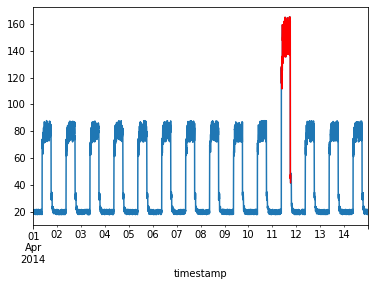

In [ ]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()